In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. DATA COLLECTION (Loading the Data)
print("Loading data from your uploaded files...")

# A. Read the CO2 file
co2_filename = 'owid-co2-data (1).csv'
gdp_filename = 'API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_130128.csv'

try:
    df_co2 = pd.read_csv(co2_filename)
    # The GDP file usually has empty rows at the top, so we skip the first 4 rows.
    df_gdp_raw = pd.read_csv(gdp_filename, skiprows=4)
    print("Files read successfully!")
except FileNotFoundError:
    print("ERROR: Files not found! Please make sure both CSV files are uploaded to Colab.")
    raise

# 2. DATA CLEANING AND PREPARATION
print("Cleaning and merging data...")

# Organize GDP Data:
# We only need the years and country codes. We filter numerical columns.
year_columns = [col for col in df_gdp_raw.columns if col.isdigit()]
cols_to_keep = ['Country Code', 'Country Name'] + year_columns
df_gdp = df_gdp_raw[cols_to_keep]

# Transform GDP data from Wide format to Long format (Rows instead of Columns)
df_gdp_melted = df_gdp.melt(id_vars=['Country Code', 'Country Name'], var_name='year', value_name='gdp')
df_gdp_melted['year'] = pd.to_numeric(df_gdp_melted['year'])

# Prepare CO2 Data:
# We select only the necessary columns.
df_co2_clean = df_co2[['iso_code', 'year', 'co2_per_capita']].copy()

# MERGE DATA:
# We combine the GDP and CO2 tables using 'Country Code' and 'Year'.
df = pd.merge(df_co2_clean, df_gdp_melted, left_on=['iso_code', 'year'], right_on=['Country Code', 'year'])

# Filter the data:
# 1. We look at years between 1990 and 2022.
# 2. We remove missing values (NaN) and zero values to avoid errors with Logarithms.
df = df[(df['year'] >= 1990) & (df['year'] <= 2022)]
df = df.dropna(subset=['co2_per_capita', 'gdp'])
df = df[(df['co2_per_capita'] > 0) & (df['gdp'] > 0)]

print(f"Data cleaned. Total rows ready for analysis: {len(df)}")
print(df.head())

# 3. EXPLORATORY DATA ANALYSIS (EDA)

# A. Summary Statistics
print("\n--- Summary Statistics (Mean, Std, Min, Max) ---")
print(df[['co2_per_capita', 'gdp']].describe())

# B. Histogram (Visualizing Distributions)
# We use a Log Scale because the data is skewed (many poor countries, few rich ones).
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['co2_per_capita'], bins=30, kde=True, ax=ax[0], color='skyblue', log_scale=True)
ax[0].set_title('Distribution of CO2 Emissions (Log Scale)')
ax[0].set_xlabel('CO2 per Capita (Tonnes) - Log Scale')

sns.histplot(df['gdp'], bins=30, kde=True, ax=ax[1], color='lightgreen', log_scale=True)
ax[1].set_title('Distribution of GDP per Capita (Log Scale)')
ax[1].set_xlabel('GDP per Capita (PPP $) - Log Scale')

plt.tight_layout()
plt.show()

# C. Scatter Plot (Analyzing the Relationship)
# We use data from 2019 to see a clear picture without overcrowding the plot.
df_2019 = df[df['year'] == 2019]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_2019, x='gdp', y='co2_per_capita', hue='gdp', palette='viridis', size='co2_per_capita', sizes=(20, 200), alpha=0.7)

# Set axes to Log Scale
plt.xscale('log')
plt.yscale('log')

# Add a Regression Line (Trend line)
sns.regplot(data=df_2019, x='gdp', y='co2_per_capita', scatter=False, color='red', line_kws={"linestyle": "--"})

plt.title('Economic Growth vs. CO2 Emissions (Year: 2019)')
plt.xlabel('GDP per Capita (Log Scale)')
plt.ylabel('CO2 per Capita (Log Scale)')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

# 4. HYPOTHESIS TESTING

print("\n--- Hypothesis Testing ---")
# We calculate the Pearson Correlation Coefficient.
# We use log-transformed data for a more accurate result.
corr_coef, p_value = stats.pearsonr(np.log(df['gdp']), np.log(df['co2_per_capita']))

print(f"Pearson Correlation Coefficient (on log-transformed data): {corr_coef:.4f}")
print(f"P-value: {p_value}")

# Interpreting the Result
alpha = 0.05
if p_value < alpha:
    print("RESULT: Null Hypothesis is REJECTED.")
    print("Interpretation: There is a statistically significant correlation between GDP and CO2 emissions.")
    if corr_coef > 0:
        print("Direction: The relationship is POSITIVE (As GDP increases, CO2 tends to increase).")
    else:
        print("Direction: The relationship is NEGATIVE.")
else:
    print("RESULT: Fail to reject Null Hypothesis.")
    print("Interpretation: No significant relationship found.")

ModuleNotFoundError: No module named 'pandas'

Checking for existing data...
'df' değişkeni bulunamadı. Veriler dosyalardan yükleniyor...
Veri başarıyla yüklendi ve birleştirildi! Toplam satır: 6473


--- TEMPORALITY ANALYSIS ---
Veriyi tek bir yılın 'fotoğrafı' gibi değil, bir 'film' gibi inceliyoruz.


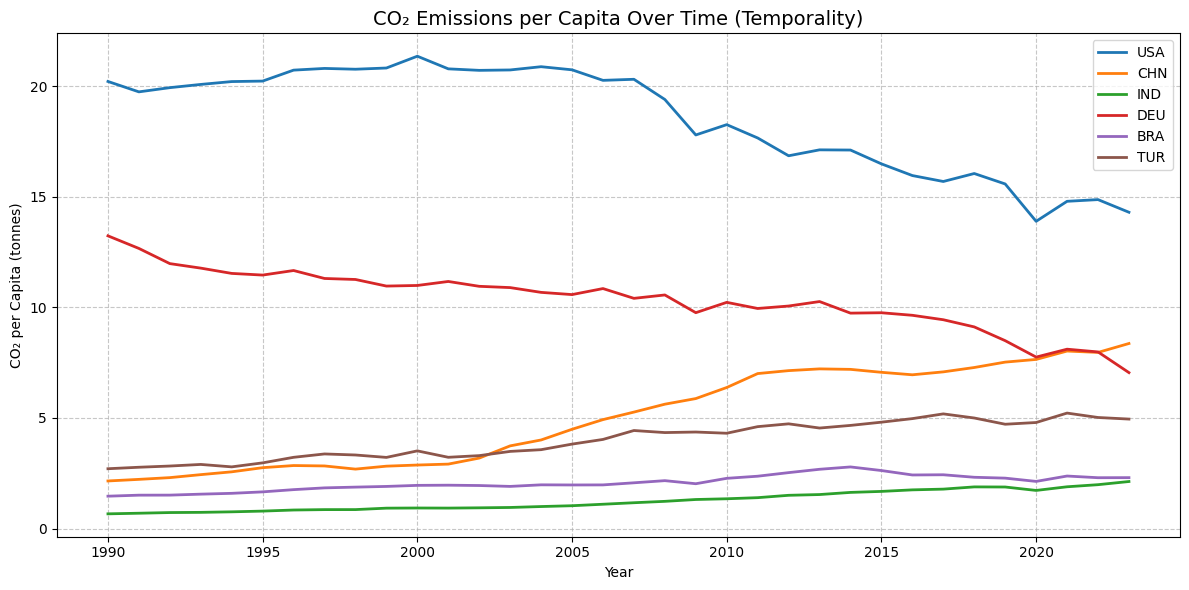

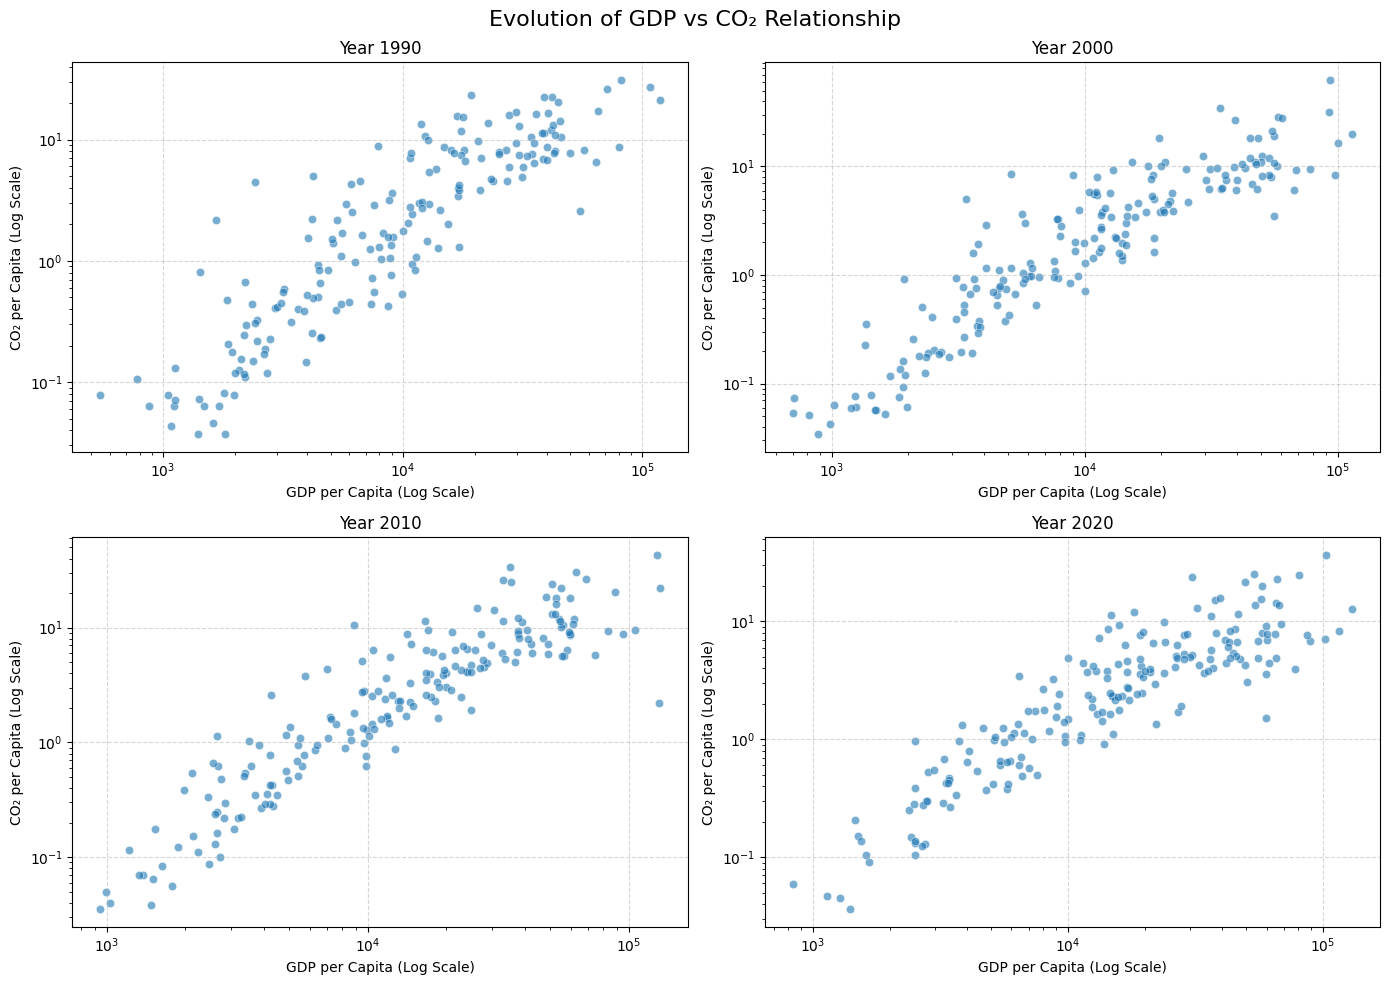


Temporality analysis completed.

--- ENVIRONMENTAL KUZNETS CURVE (EKC) HYPOTHESIS TEST ---
Hipotez: 'Ekonomik büyüme (GDP) ilk başta CO₂ emisyonlarını artırır,
ancak belirli bir gelişmişlik seviyesinden sonra emisyonlar azalmaya başlar.'

Model: CO₂ = β₀ + β₁*GDP + β₂*GDP²
--- Hypothesis Test Results (USA: Environmental Kuznets Curve) ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8459      8.563     -0.683      0.500     -23.309      11.618
GDP            0.0011      0.000      3.658      0.001       0.000       0.002
GDP_Sq     -1.138e-08   2.58e-09     -4.409      0.000   -1.66e-08   -6.12e-09


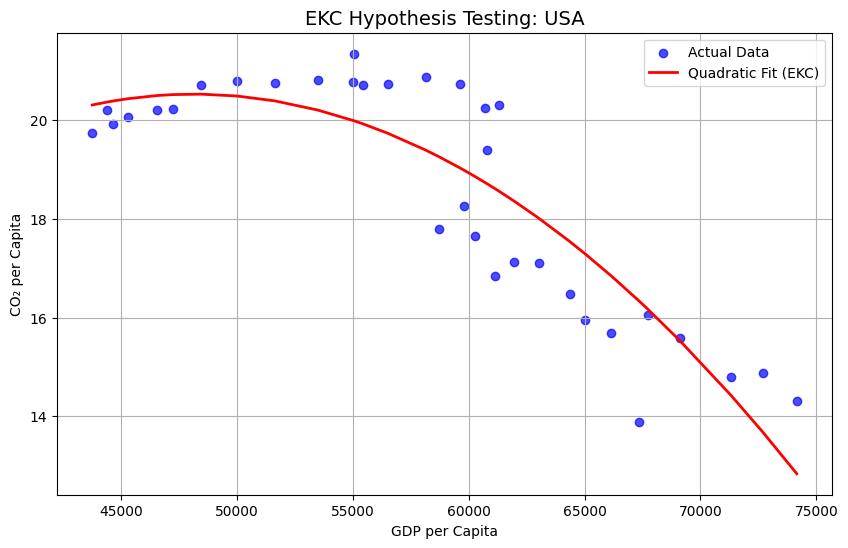


--- EKC INTERPRETATION ---
GDP² coefficient (β₂): -1.14e-08
P-value: 0.000116

✓ RESULT: EKC Hypothesis is SUPPORTED!
  → Ters U şekli gözlemlendi (Inverted U-shape found).



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 1. DATA CHECK AND PREPARATION
print("Checking for existing data...")

# Use 'df' if it exists in the Notebook, otherwise load from file
try:
    # Check if 'df' variable exists
    if 'df' in locals() or 'df' in globals():
        print("Found existing 'df' variable. Continuing analysis...")
        # Check for required columns
        required_cols = ['gdp', 'co2_per_capita', 'year', 'Country Code']
        missing_cols = [c for c in required_cols if c not in df.columns]
        if missing_cols:
            print(f"WARNING: These columns are missing in 'df': {missing_cols}")
            print("Please make sure you ran the previous cells.")
            # Try to load from file if columns are missing
            raise NameError
    else:
        raise NameError 
except NameError:
    print("'df' variable not found. Loading data from files...")
    
    try:
        # Define file names here
        gdp_file = 'API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_130128.csv'
        co2_file = 'owid-co2-data (1).csv'
        
        # Load and clean GDP data
        gdp_df = pd.read_csv(gdp_file, skiprows=4)
        cols_to_drop = ['Indicator Name', 'Indicator Code']
        for col in gdp_df.columns:
            if 'Unnamed' in col: cols_to_drop.append(col)
        gdp_clean = gdp_df.drop(columns=[c for c in cols_to_drop if c in gdp_df.columns], errors='ignore')
        gdp_long = gdp_clean.melt(id_vars=['Country Name', 'Country Code'], 
                                  var_name='year', 
                                  value_name='gdp') 
        
        gdp_long['year'] = pd.to_numeric(gdp_long['year'], errors='coerce')
        gdp_long = gdp_long.dropna(subset=['year', 'gdp'])
        gdp_long['year'] = gdp_long['year'].astype(int)

        # Load CO2 data
        co2_df = pd.read_csv(co2_file)
        co2_clean = co2_df[['iso_code', 'country', 'year', 'co2_per_capita']].copy()
        co2_clean = co2_clean.dropna(subset=['co2_per_capita', 'iso_code'])

        # Merge dataframes
        df = pd.merge(gdp_long, co2_clean, 
                      left_on=['Country Code', 'year'], 
                      right_on=['iso_code', 'year'])
        
        print(f"Data loaded and merged successfully! Total rows: {len(df)}")
    except Exception as e:
        print(f"ERROR: A problem occurred while loading data: {e}")
        print("Please check your file names and working directory.")

print("\n" + "="*80)

# ============================================================================
# 2. TEMPORALITY ANALYSIS (TIME ANALYSIS)
# ============================================================================
if 'df' in locals() or 'df' in globals():
    print("\n--- TEMPORALITY ANALYSIS ---")
    print("We analyze data like a 'movie', not just a 'photo' of one year.")

    # 2.1 Time Series Plots
    countries_to_plot = ['USA', 'CHN', 'IND', 'DEU', 'BRA', 'TUR']

    plt.figure(figsize=(12, 6))
    for code in countries_to_plot:
        subset = df[df['Country Code'] == code]
        if not subset.empty:
            subset = subset.sort_values('year')
            plt.plot(subset['year'], subset['co2_per_capita'], label=code, linewidth=2)

    plt.title('CO2 Emissions per Capita Over Time', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('CO2 per Capita (tonnes)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 2.2 Snapshots by Year
    years_to_plot = [1990, 2000, 2010, 2020]
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, year in enumerate(years_to_plot):
        subset = df[df['year'] == year]
        if not subset.empty:
            sns.scatterplot(data=subset, x='gdp', y='co2_per_capita', 
                            ax=axes[i], alpha=0.6)
            axes[i].set_title(f'Year {year}')
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].set_xlabel('GDP per Capita (Log Scale)')
            axes[i].set_ylabel('CO2 per Capita (Log Scale)')
            axes[i].grid(True, linestyle='--', alpha=0.5)

    plt.suptitle('Evolution of GDP vs CO2 Relationship', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\nTemporality analysis completed.")
    print("="*80)

    # ============================================================================
    # 3. HYPOTHESIS: ENVIRONMENTAL KUZNETS CURVE (EKC) - Quadratic Regression
    # ============================================================================
    print("\n--- ENVIRONMENTAL KUZNETS CURVE (EKC) HYPOTHESIS TEST ---")
    print("Hypothesis: 'Economic growth (GDP) increases CO2 emissions at first,")
    print("but after a certain level, emissions start to decrease.'\n")
    print("Model: CO2 = b0 + b1*GDP + b2*GDP^2")

    # 3.1 Analysis for USA
    subset_usa = df[df['Country Code'] == 'USA'].dropna().sort_values('year')

    if not subset_usa.empty and len(subset_usa) > 5:
        X_usa = subset_usa['gdp']
        y_usa = subset_usa['co2_per_capita']
        
        # Prepare data for regression (adding GDP squared)
        X_usa_df = pd.DataFrame({'GDP': X_usa, 'GDP_Sq': X_usa**2})
        X_usa_with_const = sm.add_constant(X_usa_df)
        
        # Run the model
        model_usa = sm.OLS(y_usa, X_usa_with_const).fit()
        
        print("--- Hypothesis Test Results (USA) ---")
        print(model_usa.summary().tables[1]) # Show only coefficient table
        
        # Visualization
        plt.figure(figsize=(10, 6))
        plt.scatter(subset_usa['gdp'], subset_usa['co2_per_capita'], 
                    label='Actual Data', color='blue', alpha=0.7)
        
        sort_idx = np.argsort(subset_usa['gdp'].values)
        plt.plot(subset_usa['gdp'].values[sort_idx], 
                 model_usa.predict(X_usa_with_const).values[sort_idx], 
                 color='red', label='Quadratic Fit (EKC)', linewidth=2)
        
        plt.title('EKC Hypothesis Testing: USA', fontsize=14)
        plt.xlabel('GDP per Capita')
        plt.ylabel('CO2 per Capita')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Interpretation
        print("\n--- INTERPRETATION ---")
        gdp_sq_coef = model_usa.params['GDP_Sq']
        gdp_sq_pvalue = model_usa.pvalues['GDP_Sq']
        
        print(f"GDP Squared coefficient: {gdp_sq_coef:.2e}")
        print(f"P-value: {gdp_sq_pvalue:.6f}")
        
        if gdp_sq_coef < 0 and gdp_sq_pvalue < 0.05:
            print("\n✓ RESULT: EKC Hypothesis is SUPPORTED!")
            print("  -> We see an inverted U-shape.")
            print("  -> Economy grows, but emissions go down eventually.")
        else:
            print("\n✗ RESULT: EKC Hypothesis is NOT supported.")
    else:
        print("Insufficient data for USA analysis")

    print("\n" + "="*80)
else:
    print("ERROR: Cannot start analysis because 'df' variable is missing.")